# setup

In [2]:
# !proxychains pip install -U langchain-ollama ollama

In [5]:
models = [
    "gemma3:12b", # gemma3
    "gemma3:27b",
    "gemma2:27b", # gemma2
    "gemma2:9b",
    "qwen3:32b", # qwen3
    "qwen3:14b",
    "qwen2.5:32b", # qwen2.5
    "qwen2.5:7b",
    "mistral-small3.1:24b" # misteral
]
models = dict(zip(range(len(models)), models))
models

{0: 'gemma3:12b',
 1: 'gemma3:27b',
 2: 'gemma2:27b',
 3: 'gemma2:9b',
 4: 'qwen3:32b',
 5: 'qwen3:14b',
 6: 'qwen2.5:32b',
 7: 'qwen2.5:7b',
 8: 'mistral-small3.1:24b'}

In [6]:
model = models[4]
model

'qwen3:32b'

In [7]:
base_url="http://host.docker.internal:11434"

from langchain_ollama import ChatOllama
llm = ChatOllama(
    model=model,
    base_url=base_url,
)

from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(
    model="mxbai-embed-large",
    base_url=base_url,
)

In [8]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

# Load documents

In [9]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) # openai file search chunck_size=800, chuck_overlap=400
all_splits = text_splitter.split_documents(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [10]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# tool calling

In [11]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [12]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

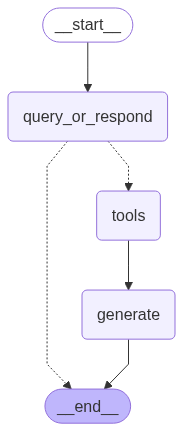

In [13]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()
graph

# Usage

In [14]:
input_message = "Hello"
input_message = f"/nothink {input_message}"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

/nothink Hello
================================== Ai Message ==================================

<think>

</think>

Hi, how can I help you today?


In [15]:
input_message = "What is Task Decomposition?"
input_message = f"/nothink {input_message}"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

/nothink What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (5ec283a2-4044-4928-af20-9473a14ca860)
 Call ID: 5ec283a2-4044-4928-af20-9473a14ca860
  Args:
    query: What is Task Decomposition?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple mana